In [224]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import math
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

### Importing the dataset

In [225]:
###Importing the dataset

df=pd.read_csv("energydata_complete.csv")

In [226]:
### Splitting classes based on its Median

df['Appliances_class'] = [0 if x <= 60 else 1 for x in df['Appliances']] 
# df_logistic = df.drop(columns = ['Appliances'])

In [227]:
df.columns

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'Appliances_class'],
      dtype='object')

In [228]:
df['Appliances_class'].value_counts()

0    10744
1     8991
Name: Appliances_class, dtype: int64

In [229]:
pd.DataFrame(df['lights'].value_counts()).T

,0,10,20,30,40,50,60,70
lights,15252,2212,1624,559,77,9,1,1


### Feature 'lights' can be removed as it has most of the data points to be 0

In [231]:
df.drop(columns=['Appliances','lights','date'],inplace=True)

In [232]:
df.columns

Index(['T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5',
       'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out',
       'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1',
       'rv2', 'Appliances_class'],
      dtype='object')

In [233]:
corr=df.corr()
print("Features with high correlation >0.85\n")
print("Feature1\tFeature2\tCorrelation")

for i in range(len(corr.columns)):
    for j in range(i):
        if(corr.iloc[i,j]>0.85):
            print(corr.columns[i],"\t\t",corr.columns[j],"\t\t", round(corr.iloc[i,j],3))
 

Features with high correlation >0.85

Feature1	Feature2	Correlation
T3 		 T1 		 0.892
T4 		 T1 		 0.877
T4 		 T3 		 0.853
RH_4 		 RH_1 		 0.88
RH_4 		 RH_3 		 0.899
T5 		 T1 		 0.885
T5 		 T3 		 0.888
T5 		 T4 		 0.872
T7 		 T4 		 0.878
T7 		 T5 		 0.871
RH_7 		 RH_4 		 0.894
T8 		 T7 		 0.882
RH_8 		 RH_7 		 0.884
T9 		 T3 		 0.901
T9 		 T4 		 0.889
T9 		 T5 		 0.911
T9 		 T7 		 0.945
T9 		 T8 		 0.869
RH_9 		 RH_4 		 0.857
RH_9 		 RH_7 		 0.859
RH_9 		 RH_8 		 0.856
T_out 		 T6 		 0.975
rv2 		 rv1 		 1.0


In [234]:
# T3, RH_4, T5, T8, RH_7, T7, RH_8, T6, rv2           
df.drop(columns=['T3','RH_4','T5','T8','RH_7','T7','RH_8','T6','rv2','Visibility','rv1'],inplace=True)

In [235]:
df.shape

(19735, 16)

### Getting the count of outliers from each column

In [236]:
q1= df.quantile(0.25)
q3 = df.quantile(0.75)
IQR = q3-q1   ###Inter-Quartile Range

upper_threshold = q3 + (1.5 * IQR)
lower_threshold = q1 - (1.5 * IQR)

outliers = dict()
column = 0
for upper,lower in zip(upper_threshold,lower_threshold):
    outliers_count = df[df.iloc[:,column]>math.ceil(upper)].shape[0] + df[df.iloc[:,column]<math.floor(lower)].shape[0]
    outliers[df.columns[column]] = outliers_count
    column = column + 1

In [237]:
outliers

{'T1': 283,
 'RH_1': 119,
 'T2': 424,
 'RH_2': 180,
 'RH_3': 4,
 'T4': 32,
 'RH_5': 1258,
 'RH_6': 0,
 'T9': 0,
 'RH_9': 0,
 'T_out': 382,
 'Press_mm_hg': 177,
 'RH_out': 226,
 'Windspeed': 124,
 'Tdewpoint': 0,
 'Appliances_class': 0}

In [238]:
df = df[(df["RH_5"] > 33.005) & (df["RH_5"] < 66.058333)]

### Feature Scaling

In [239]:
def feature_scaling(df_unscaled):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_unscaled)
    scaled_data = pd.DataFrame(scaled_data, columns = df_unscaled.columns)
    return(scaled_data)

### Train-Test Split

In [240]:
x=df.loc[:, df.columns != 'Appliances_class']
x=feature_scaling(x)
y=df['Appliances_class']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=1)


In [241]:
X_train.shape

(12883, 15)

## Support Vector Machine

### Linear Kernel

### Grid Search to get the Optimal Cost Hyperparameter

In [210]:
from sklearn.model_selection import cross_val_score

cost_values = [0.1,1,10,20]
score_list = []
for cost in cost_values:
    clf = SVC(C=cost,kernel='linear',random_state=10)
    scores = cross_val_score(clf, X_train, y_train, cv=3)
    print(cost, scores.mean())
    score_list.append(scores.mean())
    
cost_accuracy_df = pd.DataFrame({'Accuracy':score_list},index=cost_values)   

0.1 0.716293221198003
1 0.7159823488273273
10 0.7155166187730503
20 0.715671910332954


### Plot for Penalty Vs Accuracy

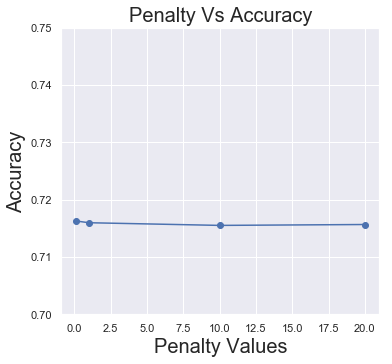

In [244]:
plt.plot(cost_accuracy_df,marker='o')
plt.xlabel('Penalty Values',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.title('Penalty Vs Accuracy',fontsize=20)
plt.ylim(0.7,0.75)
plt.show()

### We see very slight changes in the accuracies with varying cost. We choose cost 0.1 as the optimal cost hyperparameter for the Linear kernel SVM

### Learning curves for Linear kernel SVM

In [212]:
train_sizes, train_scores, valid_scores = learning_curve(SVC(C=0.1,kernel='linear'), 
    X_train, y_train,train_sizes=[0.2,0.4,0.6,0.8,1],cv=5,random_state=1,shuffle=True)

train_mean = train_scores.mean(axis=1)
valid_mean = valid_scores.mean(axis=1)

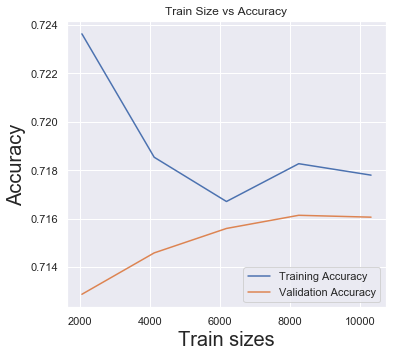

In [213]:
plt.plot(train_sizes, train_mean, label = 'Training Accuracy')
plt.plot(train_sizes, valid_mean, label = 'Validation Accuracy')
plt.xlabel("Train sizes",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
plt.title("Train Size vs Accuracy")
plt.legend(loc="lower right")
plt.show()

### Test Results Predictions

In [214]:
accuracy=dict()
svclassifier = SVC(C=0.1,kernel='linear')
svclassifier.fit(X_train, y_train)

pred_test = svclassifier.predict(X_test)
pred_train = svclassifier.predict(X_train)

print("Accuracy of training data is %.2f" %(accuracy_score(y_train,pred_train)))
print("Accuracy of test data is %.2f" %(accuracy_score(y_test,pred_test)))
accuracy['Linear'] = [accuracy_score(y_train,pred_train),accuracy_score(y_test,pred_test)]
pd.DataFrame(confusion_matrix(y_test,pred_test),index=['Actual 0','Actual 1'],columns=['Predicted 0','Predicted 1'])

Accuracy of training data is 0.72
Accuracy of test data is 0.70


,Predicted 0,Predicted 1
Actual 0,2420,633
Actual 1,1007,1462


### Polynomial Kernel

In [215]:
score_list = []
cost_values = [0.1,1,10,20]
degree_values = [1,2,3,4]
for cost in cost_values:
    for degree in degree_values:
        clf = SVC(C=cost,kernel='poly',degree=degree,gamma='auto',random_state=12)
        scores = cross_val_score(clf, X_train, y_train, cv=3)
        print(cost, scores.mean())
        score_list.append(scores.mean())

0.1 0.7107818893884793
0.1 0.6520990709533283
0.1 0.6837696547094877
0.1 0.6592406748909727
1 0.7166810885341769
1 0.7042613793777327
1 0.7471855754930755
1 0.739113451512199
10 0.7157495199565473
10 0.7295656961486517
10 0.7874709359371695
10 0.8002011920570627
20 0.7156718741765955
20 0.7351544206436175
20 0.7955430960744048
20 0.8126202503990533


In [216]:
cost_values = [0.1,1,10,20]
degree_values = [1,2,3,4]
cost_values = [0.1,1,10,20]*4
cost_values.sort()
degree_values = [1,2,3,4]*4

cost_degree_accuracy = pd.DataFrame({'Degree':degree_values,'Cost':cost_values,'Accuracy':score_list})

### Accuracy with varying penalities and degree

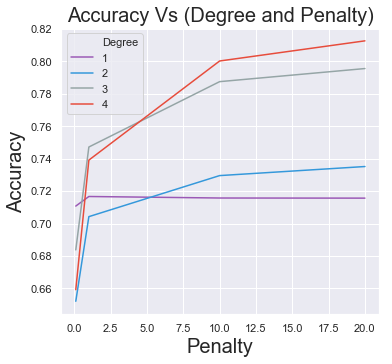

In [219]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c"]
ax = sns.lineplot(data=cost_degree_accuracy, x='Cost', y='Accuracy',hue='Degree',palette=flatui)
ax.set(xlabel='Penalty', ylabel='Accuracy')
plt.rcParams["axes.labelsize"] = 20
plt.title('Accuracy Vs (Degree and Penalty)',fontsize=20)
plt.show()

### Learning curves for Polynomial kernel SVM

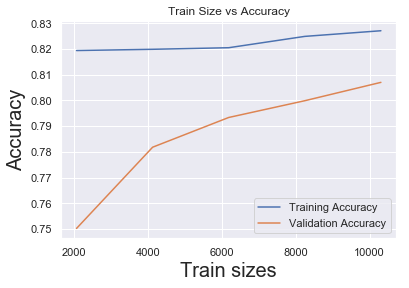

In [64]:
train_sizes, train_scores, valid_scores = learning_curve(SVC(C=10,kernel='poly',degree=4,gamma='auto'), 
    X_train, y_train,train_sizes=[0.2,0.4,0.6,0.8,1],cv=5,random_state=5,shuffle=True)

train_mean = train_scores.mean(axis=1)
valid_mean = valid_scores.mean(axis=1)

### Test Results Predictions

In [79]:
svclassifier = SVC(C=20,kernel='poly',degree=4,gamma='auto')
svclassifier.fit(X_train, y_train)

pred_test = svclassifier.predict(X_test)
pred_train = svclassifier.predict(X_train)

print("Accuracy of training data is %.2f" %(accuracy_score(y_train,pred_train)))
print("Accuracy of test data is %.2f" %(accuracy_score(y_test,pred_test)))
accuracy['Polynomial'] = [accuracy_score(y_train,pred_train),accuracy_score(y_test,pred_test)]
pd.DataFrame(confusion_matrix(y_test,pred_test),index=['Actual 0','Actual 1'],columns=['Predicted 0','Predicted 1'])

Accuracy of training data is 0.84
Accuracy of test data is 0.82


,Predicted 0,Predicted 1
Actual 0,2780,273
Actual 1,714,1755


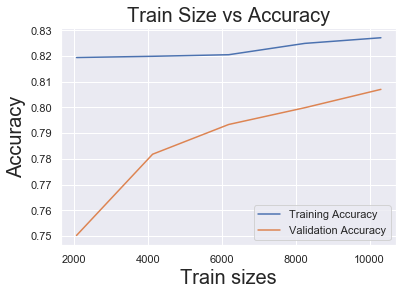

In [65]:
plt.plot(train_sizes, train_mean, label = 'Training Accuracy')
plt.plot(train_sizes, valid_mean, label = 'Validation Accuracy')
plt.xlabel("Train sizes",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
plt.title("Train Size vs Accuracy",fontsize=20)
plt.legend(loc="lower right")
plt.show()

### Radial Basis Function

In [220]:
score_list = []
cost_values = [0.1,1,10,20]
gamma_values = [0.01,0.05,0.001,0.005]
for cost in cost_values:
    for gamma in gamma_values:
        clf = SVC(C=cost,kernel='rbf',gamma=gamma)
        scores = cross_val_score(clf, X_train, y_train, cv=3)
        print(cost, scores.mean())
        score_list.append(scores.mean())

0.1 0.7106255492941781
0.1 0.7380264829055901
0.1 0.6397575860785726
0.1 0.6940149204636944
1 0.7395792177228345
1 0.7920507714817807
1 0.7091510749149806
1 0.7298765323629689
10 0.7676780956012084
10 0.8343540182956598
10 0.7273153786280306
10 0.7455560988048425
20 0.7780784359771676
20 0.8425818315563839
20 0.7304195466336125
20 0.7525420134626394


In [67]:
cost_values = [0.1,1,10,20]
gamma_values = [0.01,0.05,0.001,0.005]
cost_values = [0.1,1,10,20]*4
cost_values.sort()
gamma_values = [0.01,0.05,0.001,0.005]*4

cost_gamma_accuracy = pd.DataFrame({'Gamma':gamma_values,'Cost':cost_values,'Accuracy':score_list})

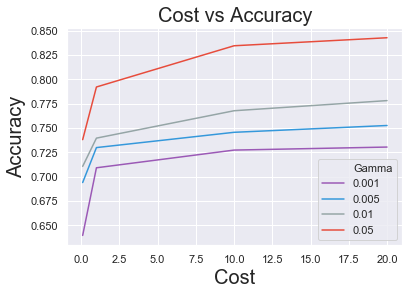

In [72]:
import seaborn as sns
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c"]
sns.lineplot(data=cost_gamma_accuracy, x='Cost', y='Accuracy',hue='Gamma',palette=flatui)
plt.xlabel("Penalty",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
plt.legend(loc="lower right")
plt.show()

### Learning curves for Radial kernel SVM

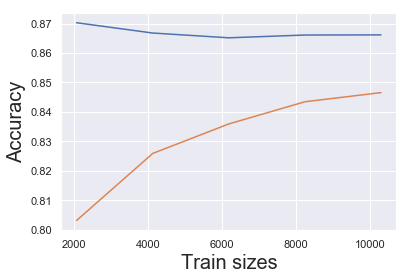

In [73]:
train_sizes, train_scores, valid_scores = learning_curve(SVC(C=20,kernel='rbf',gamma=0.05), 
    X_train, y_train,train_sizes=[0.2,0.4,0.6,0.8,1],cv=5,random_state=5,shuffle=True)

train_mean = train_scores.mean(axis=1)
valid_mean = valid_scores.mean(axis=1)


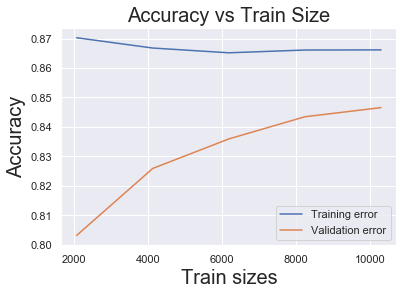

In [76]:
plt.plot(train_sizes, train_mean, label = 'Training Accuracy')
plt.plot(train_sizes, valid_mean, label = 'Validation Accuracy')
plt.xlabel("Train sizes",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
plt.legend(loc="lower right")
plt.title("Accuracy vs Train Size",fontsize=20)
plt.show()

### Test Results Predictions

In [77]:
accuracy=dict()
svclassifier = SVC(C=20,gamma=0.05,kernel='rbf')
svclassifier.fit(X_train, y_train)

pred_test = svclassifier.predict(X_test)
pred_train = svclassifier.predict(X_train)

print("Accuracy of training data is %.2f" %(accuracy_score(y_train,pred_train)))
print("Accuracy of test data is %.2f" %(accuracy_score(y_test,pred_test)))
accuracy['Radial'] = [accuracy_score(y_train,pred_train),accuracy_score(y_test,pred_test)]
pd.DataFrame(confusion_matrix(y_test,pred_test),index=['Actual 0','Actual 1'],columns=['Predicted 0','Predicted 1'])

Accuracy of training data is 0.87
Accuracy of test data is 0.84


,Predicted 0,Predicted 1
Actual 0,2673,380
Actual 1,487,1982


### Decision Trees

In [80]:
x=df.loc[:, df.columns != 'Appliances_class']
y=df['Appliances_class']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=1)

In [81]:
X_train.head()

,T1,RH_1,T2,RH_2,RH_3,T4,RH_5,RH_6,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Tdewpoint
690,22.166667,41.230000,21.60,40.500000,42.590000,20.50,44.500000,96.190000,17.89,45.126667,4.700000,763.900000,87.000000,3.000000,2.700000
13621,22.000000,45.426667,19.60,48.566667,42.266667,22.00,51.326667,61.430000,20.79,45.900000,9.633333,747.766667,92.500000,4.333333,8.466667
10834,23.000000,41.933333,21.70,43.200000,39.500000,20.29,46.333333,35.790000,19.79,40.500000,13.233333,747.700000,63.000000,7.333333,6.300000
18201,22.790000,39.290000,20.60,40.290000,37.856000,22.89,41.634000,34.448571,22.70,40.090000,9.050000,760.100000,83.500000,1.500000,6.300000
7375,22.100000,37.260000,20.79,37.000000,38.590000,20.89,51.266667,81.400000,18.10,36.730000,2.500000,744.400000,85.666667,8.500000,0.316667


### HyperParameter Tuning to choose the optimal Tree depth and Maximum Features

In [110]:
decision_tree_df=pd.DataFrame()
depth_values = [3,4,5,6,7,8,9,10,11,12,13,14,15]
max_features = [0.2,0.4,0.6,0.8,1]
for depth in depth_values:
    for features in max_features:
        clf = DecisionTreeClassifier(criterion='entropy',max_depth=depth,max_features=features)
        scores = cross_val_score(clf, X_train, y_train, cv=5)
        values  =  [depth,features,scores.mean()]
        values = pd.DataFrame(values).T
        decision_tree_df = pd.concat([decision_tree_df,values])
        
decision_tree_df.columns=['Depth','Max Features','Accuracy']     

### Accuracy Vs (Depth and Max_Features)

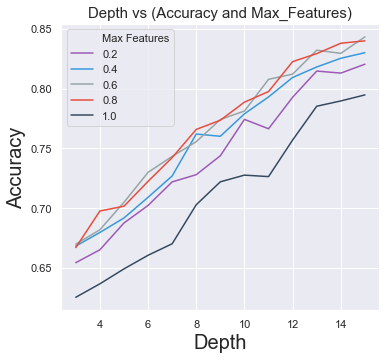

In [111]:
import seaborn as sns
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c","#34495e"]
sns.set(rc={'figure.figsize':(5.7,5.27)})
sns.lineplot(data=decision_tree_df, x='Depth', y='Accuracy',hue='Max Features',palette=flatui)
plt.xlabel("Depth",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
plt.title("Depth vs (Accuracy and Max_Features)",fontsize=15)
plt.show()

In [113]:
accuracy_dt=dict()
for depth in range(1,15):
    clf = DecisionTreeClassifier(criterion='entropy',max_depth=depth,max_features=0.8)  ###Criteria: Entropy
    clf.fit(X_train,y_train)   ### Model fitting
    pred_train = clf.predict(X_train)  ### Training set Prediction
    pred_test = clf.predict(X_test)    ### Testing set Prediction
    
    accuracy_dt[depth]=[accuracy_score(y_train, pred_train).round(3),accuracy_score(y_test, pred_test).round(4)]
    
accuracy_dt_df = pd.DataFrame(accuracy_dt,index=['Train','Test']).T

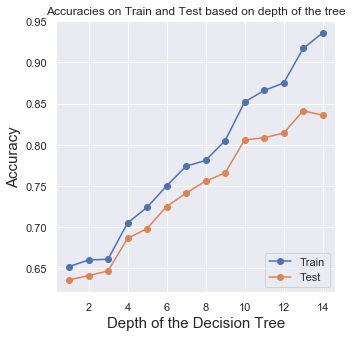

In [126]:
plt.figure(figsize=(5,5))
plt.plot(accuracy_dt_df,marker='o')
plt.xlabel('Depth of the Decision Tree',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.title("Accuracies on Train and Test based on depth of the tree",fontsize=12)
plt.legend(['Train','Test'],loc="lower right")
plt.show()

### Plot to get the Best Features based on their Information Gain

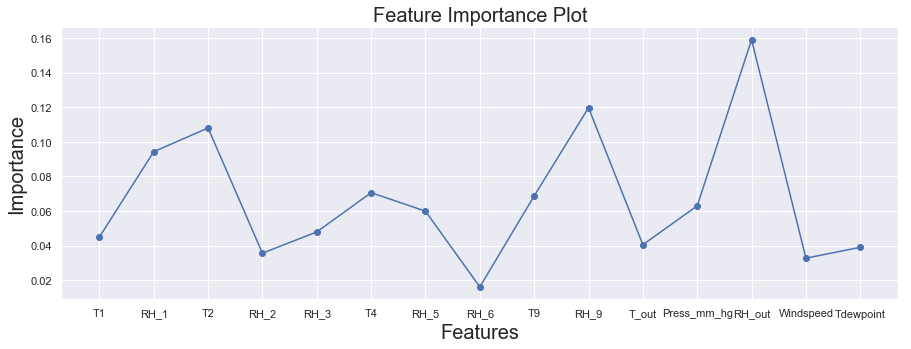

In [132]:
clf = DecisionTreeClassifier(criterion='entropy',max_depth=10,max_features=0.8)  ###Criteria: Entropy
clf.fit(X_train,y_train)
best_features=dict(zip(X_train.columns, clf.feature_importances_.round(4)))
best_features=pd.DataFrame(best_features,index=['Importance']).T
plt.figure(figsize=(15,5))
plt.plot(best_features,marker='o')
plt.xlabel('Features',fontsize=20)
plt.ylabel('Importance',fontsize=20)
plt.title('Feature Importance Plot',fontsize=20)
plt.show()

### Learning curves for Decision Trees

In [102]:
train_sizes, train_scores, valid_scores = learning_curve(DecisionTreeClassifier(criterion='entropy',max_depth=10,max_features=0.8), 
    X_train, y_train,train_sizes=[0.2,0.4,0.6,0.8,1],cv=5,shuffle=True,random_state=5)

train_mean = train_scores.mean(axis=1)
valid_mean = valid_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label = 'Training error')
plt.plot(train_sizes, valid_mean, label = 'Validation error')
plt.xlabel('Train Size',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.title('Training Size Vs Accuracy',fontsize=20)
plt.legend(['Train','Test'],loc="lower right")
plt.show()

### Test Result Predictions

In [153]:
# accuracy_decision_tree=dict()
classifier = DecisionTreeClassifier(max_depth=10,max_features=0.8)
classifier.fit(X_train, y_train)

pred_test = classifier.predict(X_test)
pred_train = classifier.predict(X_train)
    
print("Accuracy of training data is %.2f" %(accuracy_score(y_train,pred_train)))
print("Accuracy of test data is %.2f" %(accuracy_score(y_test,pred_test)))
# accuracy_decision_tree['DecisionTree'] = [accuracy_score(y_train,pred_train),accuracy_score(y_test,pred_test)]
pd.DataFrame(confusion_matrix(y_test,pred_test),index=['Actual 0','Actual 1'],columns=['Predicted 0','Predicted 1'])

Accuracy of training data is 0.86
Accuracy of test data is 0.80


,Predicted 0,Predicted 1
Actual 0,2662,391
Actual 1,737,1732


### Boosting using Adaboost Algorithm

In [164]:
boosting_df=pd.DataFrame()
learners_values = [5,10,25,50,75,100]
learning_rates = [0.01, 0.1, 0.5, 1]
for lrate in learning_rates:
    for learners in learners_values:
        estimator = AdaBoostClassifier(DecisionTreeClassifier(criterion='entropy',max_depth=10,max_features=0.8),
                                       n_estimators=learners,learning_rate=lrate)
        scores = cross_val_score(estimator, X_train, y_train, cv=5)
        values  =  [lrate,learners,scores.mean()]
        values = pd.DataFrame(values).T
        boosting_df = pd.concat([boosting_df,values])
        
boosting_df.columns=['lrate','Learners','Accuracy']  
boosting_df = boosting_df.reset_index()

### Accuracy Vs (Learning rate and Number of Learners)

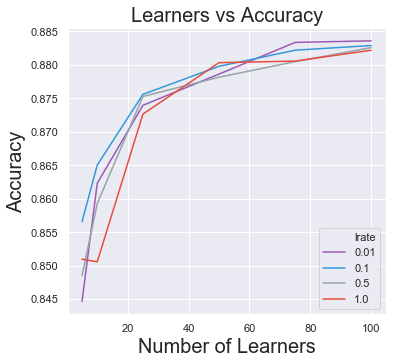

In [165]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c"]
sns.lineplot(data=boosting_df, x='Learners', y='Accuracy',hue='lrate',palette=flatui)
plt.xlabel("Number of Learners",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
plt.title("Learners vs Accuracy",fontsize=20)
plt.legend(loc="lower right")
plt.show()

In [166]:
accuracy_dt=dict()
for depth in range(1,15):
    clf = AdaBoostClassifier(DecisionTreeClassifier(criterion='entropy',max_depth=depth,max_features=0.8),
                             n_estimators=50,learning_rate=1)
    clf.fit(X_train,y_train)   ### Model fitting
    pred_train = clf.predict(X_train)  ### Training set Prediction
    pred_test = clf.predict(X_test)    ### Testing set Prediction
    
    accuracy_dt[depth]=[accuracy_score(y_train, pred_train).round(3),accuracy_score(y_test, pred_test).round(4)]
    
accuracy_dt_df = pd.DataFrame(accuracy_dt,index=['Train','Test']).T



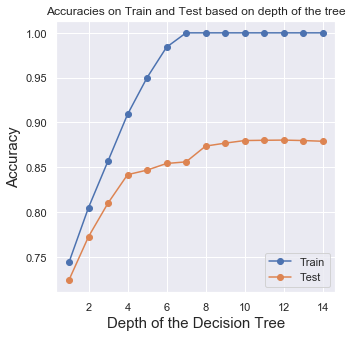

In [167]:
plt.figure(figsize=(5,5))
plt.plot(accuracy_dt_df,marker='o')
plt.xlabel('Depth of the Decision Tree',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.title("Accuracies on Train and Test based on depth of the tree",fontsize=12)
plt.legend(['Train','Test'],loc="lower right")
plt.show()

### Learning Curve 

In [169]:
estimator=AdaBoostClassifier(DecisionTreeClassifier(max_depth=5,max_features=0.8),n_estimators=50,
                             learning_rate=1)
train_sizes, train_scores, valid_scores = learning_curve(estimator, X_train, y_train,
                                                         train_sizes=[0.2,0.4,0.6,0.8,1],cv=5,random_state=1,shuffle=True)


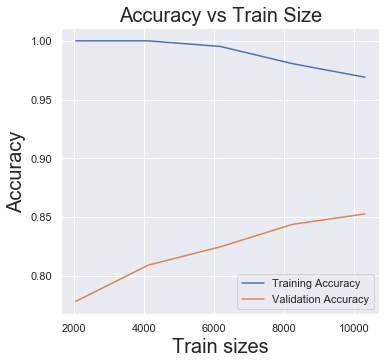

In [170]:
train_mean = train_scores.mean(axis=1)
valid_mean = valid_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label = 'Training Accuracy')
plt.plot(train_sizes, valid_mean, label = 'Validation Accuracy')
plt.xlabel("Train sizes",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
plt.legend(loc="lower right")
plt.title("Accuracy vs Train Size",fontsize=20)
plt.show()

### Test Results Predictions

In [171]:
accuracy_boosting=dict()
classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5,max_features=0.8),
                                n_estimators=50,learning_rate=1,random_state=1)
classifier.fit(X_train, y_train)

pred_test = classifier.predict(X_test)
pred_train = classifier.predict(X_train)
    
print("Accuracy of training data is %.2f" %(accuracy_score(y_train,pred_train)))
print("Accuracy of test data is %.2f" %(accuracy_score(y_test,pred_test)))
accuracy_boosting['Boosting'] = [accuracy_score(y_train,pred_train),accuracy_score(y_test,pred_test)]
pd.DataFrame(confusion_matrix(y_test,pred_test),index=['Actual 0','Actual 1'],columns=['Predicted 0','Predicted 1'])

Accuracy of training data is 0.96
Accuracy of test data is 0.86


,Predicted 0,Predicted 1
Actual 0,2716,337
Actual 1,446,2023


In [159]:
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      3053
           1       0.85      0.82      0.84      2469

    accuracy                           0.86      5522
   macro avg       0.86      0.85      0.85      5522
weighted avg       0.86      0.86      0.86      5522



### Model comparisons using Cross Validation

In [175]:
cross_validation_comparisons = pd.DataFrame()
estimators = [SVC(C=20,gamma=0.05,kernel='rbf'),
              DecisionTreeClassifier(criterion='entropy',max_depth=10,max_features=0.8),
              AdaBoostClassifier(DecisionTreeClassifier(criterion='entropy',max_depth=5,max_features=0.8),n_estimators=50,learning_rate=1,random_state=1)]
models = ['Radial SVM', 'Decision Tree', 'Boosted']
for model in range(len(models)):
    scores = cross_val_score(estimators[model], X_train, y_train, cv=5)
    scores = pd.DataFrame(scores).T
    cross_validation_comparisons = pd.concat([cross_validation_comparisons,scores])

cross_validation_comparisons.columns=['Split 1','Split 2','Split 3','Split 4','Split 5'] 
cross_validation_comparisons.index = ['SVC','DecisionTree','BoostedDecisionTree']

In [178]:
cross_validation_comparisons

,Split 1,Split 2,Split 3,Split 4,Split 5
SVC,0.867676,0.880869,0.879705,0.870004,0.858252
DecisionTree,0.790066,0.792006,0.797439,0.801319,0.790291
BoostedDecisionTree,0.854482,0.838184,0.861079,0.848661,0.830291


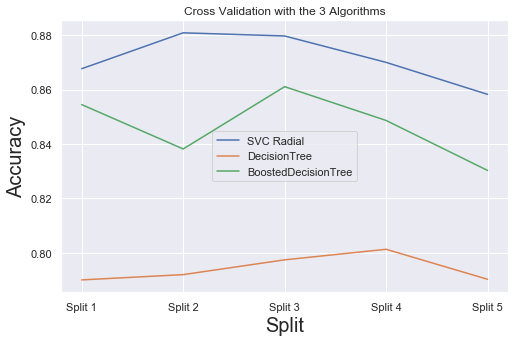

In [192]:
plt.figure(figsize=(8,5))
plt.plot(cross_validation_comparisons.T)
plt.title("Cross Validation with the 3 Algorithms")
plt.xlabel("Split",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
plt.legend(['SVC Radial','DecisionTree','BoostedDecisionTree'])
plt.show()